# Implement of XGBoost algorithm from scratch & apply it for "arcene_datasets"

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

## Data Pre-Processing:

This code seems to convert two textual data arcene files (characteristics and labels) to CSV files to facilitate their use, in automatic learning tasks, by organizing them in distinct columns with appropriate headers, the columns are named feature_1 Until feature_1000, and the label columns called Labels.

In [3]:
with open('arcene_datasets/arcene_train.data', 'r') as data, open('csv_arcene_train.csv' ,'w', newline='') as outfile:
    rows = data.readlines()
    writer = csv.writer(outfile)
    # Write a header line in the CSV file, creating column names for the 10,000 characteristics, called 'feature_1', 'feature_2', ..., 'feature_10000'.
    writer.writerow(['feature_{}'.format(i+1) for i in range(0, 10000)]) 
    
    # Divide each line into individual values ​​using space as a separator, converts them into whole, and stores them in a list called values.
    for row in rows:
        values = [int(val) for val in row.strip().split()] 

        writer.writerow(values)
        
# For the labels column
with open('arcene_datasets/arcene_train.labelS', 'r') as labels, open('csv_arcene_train_labels.csv' ,'w', newline='') as outfile:
    rows = labels.readlines()
    writer = csv.writer(outfile)
    
    writer.writerow(['labels'])
    
    for row in rows:
        values = [int(val) for val in row.strip().split()]
        writer.writerow(values)

We do the same for the Arcene_valid Dataset which will be our test Dataset.

In [4]:
with open('arcene_datasets/arcene_valid.data', 'r') as data, open('csv_arcene_valid.csv' ,'w', newline='') as outfile:
    rows = data.readlines()
    writer = csv.writer(outfile)
    
    writer.writerow(['feature_{}'.format(i+1) for i in range(0, 10000)])
    
    for row in rows:
        values = [int(val) for val in row.strip().split()]
        writer.writerow(values)
        
# for the labels
with open('arcene_datasets/arcene_valid.labelS', 'r') as labels, open('csv_arcene_valid_labels.csv' ,'w', newline='') as outfile:
    rows = labels.readlines()
    writer = csv.writer(outfile)
    
    writer.writerow(['labels'])
    
    for row in rows:
        values = [int(val) for val in row.strip().split()]
        writer.writerow(values)

In [5]:
test_features = pd.read_csv('csv_arcene_valid.csv') # load test attributes.
test_labels = pd.read_csv('csv_arcene_valid_labels.csv') # Loads the columns of testing classes.
train_features = pd.read_csv('csv_arcene_train.csv') # charge training attributes.
train_labels = pd.read_csv('csv_arcene_train_labels.csv') # Loads the columns of testing classes.

In [6]:
# Replace all the occurrences of the value -1 by 0 in the label column
test_labels = test_labels.replace(-1, 0)
train_labels = train_labels.replace(-1, 0)

This method is used to simplify dataset manipulation. This operation is often used in classification problems where labels can be coded differently.

In [7]:
train_dataset = pd.concat([train_features, train_labels], axis=1) # Merge the characteristics (features) of training with their label.
test_dataset = pd.concat([test_features, test_labels], axis=1) # Merge the characteristics (features) of testing with their label.

In [8]:
# Save the result in a CSV file named arcene_tarin_dataset.csv
train_dataset.to_csv('arcene_train_dataset.csv', index=False)

# Save the result in a CSV file named arcene_test_dataset.csv
test_dataset.to_csv('arcene_test_dataset.csv', index=False) 

<Axes: >

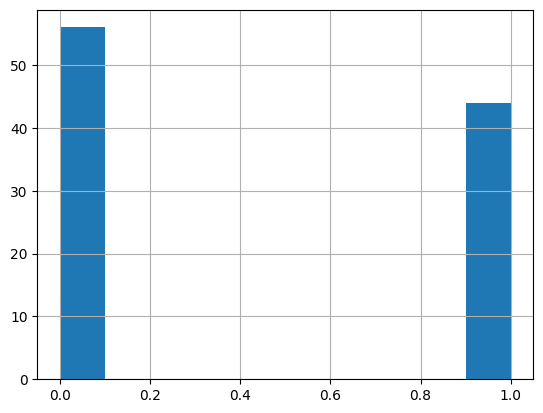

In [10]:
train_dataset['labels'].hist() # Create a histogram of the values ​​present in the labels column

In [11]:
neg_ex = train_dataset[train_dataset['labels'] == 0]
pos_ex = train_dataset[train_dataset['labels'] == 1]

print(f"Les cas tester Positive (+1): {len(pos_ex)}")
print(f"Les cas tester Negative (0): {len(neg_ex)}")

Les cas tester Positive (+1): 44
Les cas tester Negative (0): 56


In [18]:
train_dataset.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_9992,feature_9993,feature_9994,feature_9995,feature_9996,feature_9997,feature_9998,feature_9999,feature_10000,labels
0,0,71,0,95,0,538,404,20,0,0,...,570,86,0,36,0,80,0,0,524,1
1,0,41,82,165,60,554,379,0,71,0,...,605,69,7,473,0,57,0,284,423,0
2,0,0,1,40,0,451,402,0,0,0,...,593,28,0,24,0,90,0,34,508,1
3,0,56,44,275,14,511,470,0,0,0,...,600,0,26,86,0,102,0,0,469,1
4,105,0,141,348,0,268,329,0,0,1,...,0,0,0,0,190,301,0,0,354,0


In [20]:
train_dataset.shape

(100, 10001)

## Data minimization:

Data minimization, or "feature selection" in English, is a frequently used practice in the most important or most relevant characteristics (features) for a model.

Our data set contains 10,000 attributes, which is too much and which contain values ​​that do not give important results. Our data set therefore requires a selection of features and to achieve this, we suggest 2 techniques:

#### 1-Elimination of columns which only have 0 or which have more than 65 zero:

In [21]:
columns_to_drop = []
for column in train_dataset.columns[:-1]:
    zero = 0
    for x in train_dataset[column]:
        if x == 0:
            zero +=1
    if zero >= 65:
        columns_to_drop.append(column)

In [22]:
len(columns_to_drop)

2944

In [23]:
train_dataset = train_dataset.drop(columns=columns_to_drop) 
test_dataset = test_dataset.drop(columns=columns_to_drop)

In [102]:
train_dataset.shape, test_dataset.shape

((100, 2220), (100, 2220))

Well, we have reduced our dataset to 2220 columns.
Now let's move on to the second method.

#### 2-Minimization by Correlation Calculation

Is a common method to reduce the number of features in a dataset. Correlation measures the relationship and independence between two variables.

In [29]:
# Initialization of the correlation matrix
correlation_matrix = train_dataset.iloc[:,:-1].corr()

In [30]:
# Set correlation threshold
threshold = 0.9

# Find highly correlated feature pairs
paires_corr = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            nom_colonne_i = correlation_matrix.columns[i]
            nom_colonne_j = correlation_matrix.columns[j]
            paires_corr.add((nom_colonne_i, nom_colonne_j))

# Remove one column from each pair of highly correlated featurescolonnes_a_supprimer = set()
for paire in paires_corr:
    col1, col2 = paire
    # Delete one of the columns
    colonnes_a_supprimer.add(col1)

# Delete identified columns
train_df_filtre = train_dataset.drop(columns=colonnes_a_supprimer)
test_df_filtre = test_dataset.drop(columns=colonnes_a_supprimer)

In [33]:
len(colonnes_a_supprimer)

4837

In [34]:
# save results
train_dataset = train_df_filtre
test_dataset = test_df_filtre

In [35]:
train_dataset.to_csv('tarin_dataset_minimiser.csv', index=False)
test_dataset.to_csv('test_dataset_minimiser.csv', index=False)

In [36]:
train_dataset.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_11,...,feature_9946,feature_9951,feature_9953,feature_9967,feature_9968,feature_9976,feature_9988,feature_9993,feature_9999,labels
0,0,71,0,95,0,538,404,0,0,0,...,0,59,0,162,54,0,0,86,0,1
1,0,41,82,165,60,554,379,71,0,0,...,0,110,36,19,96,0,63,69,284,0
2,0,0,1,40,0,451,402,0,0,0,...,0,277,0,0,23,0,14,28,34,1
3,0,56,44,275,14,511,470,0,0,0,...,0,0,0,54,12,0,26,0,0,1
4,105,0,141,348,0,268,329,0,1,0,...,0,0,11,0,83,93,1,0,0,0


In [37]:
train_dataset.shape

(100, 2220)

Après le processus de minimisation, nous restent avec un ensemble de données filtré comportant 100 lignes et 2220 caractiristique.

# Implémentation de modèle Gaussien de native bayes pour la classification:

Le modèle naïf bayésien gaussien (Gaussian Naive Bayes en anglais) est une variante du classificateur naïf bayésien classique.
Ce modèle est souvent utilisé pour des tâches de classification où les caractéristiques sont continues et peuvent être modélisées par une distribution gaussienne, bien que son hypothèse de caractéristiques indépendantes (d'où le terme "naïf") puisse ne pas toujours correspondre à la réalité dans des situations plus complexes.

## Calcule de la priori P(Y=y) pour chaque class y de Y

Calcule la probabilité a priori de chaque classe en comptant le nombre d'occurrences de chaque classe et en le divisant par la taille totale de l'ensemble de données.

In [38]:
def calcule_priori(df, Y):
    classes = sorted(list(df[Y].unique()))
    priori = []
    for i in classes:
        priori.append(len(df[df[Y]==i])/len(df)) 
    return priori # Returns the list of prior probabilities for each class

In [39]:
calcule_priori(train_dataset, 'labels') # Displays the probability of each class for our arcene dataset

[0.56, 0.44]

## Computes the likelihood P(X=x|Y=y) using the Gaussian distribution of the normal law


This function is responsible for calculating the likelihood of a feature value for a given class in the context of the Gaussian Naïve Bayes classifier.
The likelihood is calculated using the probability density formula of the Gaussian distribution for the value feat_val given the class label: ![image.png](attachment:image.png)
With:

x : The value for which we want to calculate the probability density.

μ : The mean of the Gaussian distribution.

σ : The standard deviation of the Gaussian distribution.

In [40]:
def calcule_vraisemblance(df, feat_name, feat_val, Y, label):
    df_subset = df[df[Y]==label]

    mean, std = df_subset[feat_name].mean(), df_subset[feat_name].std()

    epsilon = 0.01
    std_smoothed = std if std != 0 else epsilon

    p_x_y = (1 / (np.sqrt(2 * np.pi) * std_smoothed)) * np.exp(-((feat_val - mean)**2 / (2 * std_smoothed**2)))

    return p_x_y

## Compute P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all classes y and return the maximum

This function uses the calculate_priori() and calculate_likelihood() functions to estimate the prior probabilities and conditional probabilities respectively, in order to predict the classes for the given examples.

In [41]:
def naive_bayes_gaussian(df, X, Y):
    features = list(df.columns)[:-1]

    priori = calcule_priori(df, Y)

    Y_pred = []

    for x in X:

        labels = sorted(list(df[Y].unique()))
        vraisemblance = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                vraisemblance[j] *= calcule_vraisemblance(df, features[i], x[i], Y, labels[j])

        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = vraisemblance[j] * priori[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

### Testing the Gaussian model

In [97]:
train = train_dataset
test = test_dataset

X_test = test
Y_test = test.iloc[:, -1:]

In [98]:
X_test = X_test.values
Y_test = Y_test.values

In [99]:
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="labels")

Accuracy: 0.56
F1 Score: 0.0


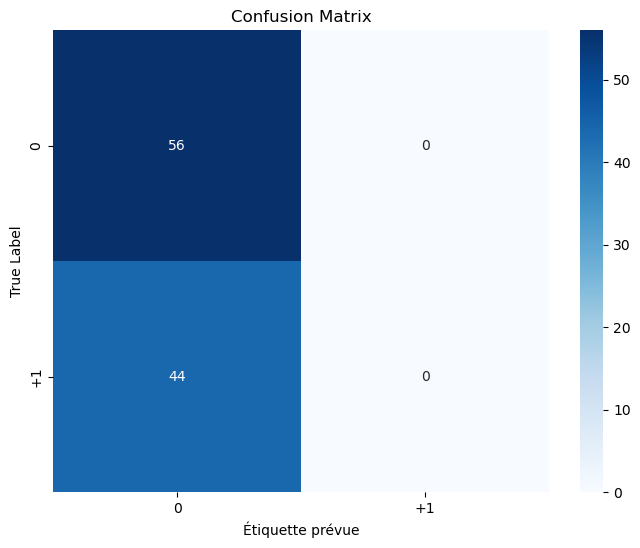

In [100]:
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy}")

# Afficher le f1_score
f1 = f1_score(Y_test, Y_pred)
print(f"F1 Score: {f1}")


# tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '+1'], 
            yticklabels=['0', '+1'])
plt.xlabel('Étiquette prévue')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [101]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        56
           1       0.00      0.00      0.00        44

    accuracy                           0.56       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.31      0.56      0.40       100



## Implémentation d'un modèle Gaussien pour une classification binaire en utilisant Python et la bibliothèque Sk-learn :

Accuracy: 0.73
F1 Score: 0.6197183098591549


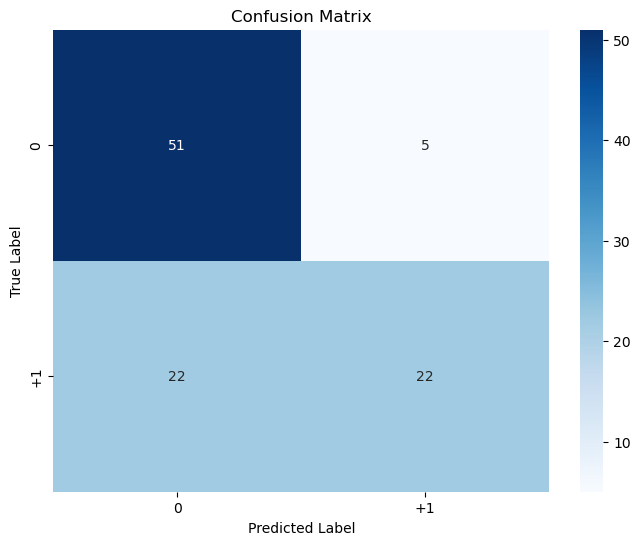

In [48]:
# Importation de la model GaussianNB de la bibli
from sklearn.naive_bayes import GaussianNB


# Répartition Train-Test
X_train = train_dataset.iloc[:, :-1]
X_test = test_dataset.iloc[:, :-1]
y_train = train_dataset['labels']
y_test = test_dataset['labels']

# entrainement de model
model = GaussianNB()
model.fit(X_train, y_train)

# Evaluation du model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


# tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '+1'], 
            yticklabels=['0', '+1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79        56
           1       0.81      0.50      0.62        44

    accuracy                           0.73       100
   macro avg       0.76      0.71      0.71       100
weighted avg       0.75      0.73      0.72       100



### Performance comparison between the two Naive Bayesian Gaussian models:

The "naive_bayes_gaussian()" model has a precision of 0.56 for class 0, but it fails to identify class 1 with a recall and precision of 0.00. Its overall accuracy is 0.56, indicating a limited ability to generalize for both classes.

In contrast, the "GaussianNB()" model has a better precision for class 0 (0.70) and also manages to identify this class well with a high recall of 0.91. For class 1, its precision is 0.81 and its recall is 0.50, showing a relatively good ability to identify this class. Its overall accuracy is 0.73, indicating a better ability to generalize to both classes.

In simple terms, the "GaussianNB()" model significantly outperforms "naive_bayes_gaussian()" in terms of its ability to predict and generalize for both classes, with more balanced precision and recall scores for each class and overall higher accuracy.

# XGBoost model implementation for classification:

XGBoost (Extreme Gradient Boosting) is an ensemble learning method that uses decision trees as base learners. More precisely, it builds an ensemble of decision trees sequentially, where each new tree attempts to correct the errors made by the previous ones.

XGBoost is particularly effective with continuous numerical data. It handles numerical features well and can identify complex patterns within these types of variables.

### Decision tree functions:

The function calculate_entropy(y) calculates the entropy of a set of target values ​​y following the entropy formula: H(X) = −∑ni = 1p(xi)⋅log2(p(xi))

In [50]:
def calculate_entropy(y):
    class_counts = y.value_counts(normalize=True) 

    entropy = -(class_counts * np.log2(class_counts)).sum()
    return entropy

This split_dataset() function splits a dataset into two parts based on a specific feature and a given threshold.

In [52]:
def split_dataset(X, y, feature_name, threshold):
    left_indices = X[feature_name] <= threshold
    right_indices = X[feature_name] > threshold

    left_X, right_X = X[left_indices], X[right_indices]
    left_y, right_y = y[left_indices], y[right_indices]

    return left_X, right_X, left_y, right_y

This function finds the best feature and threshold to split the data while minimizing entropy.

In [53]:
def find_best_split(X, y):
    best_entropy = float('inf')
    best_feature_name, best_threshold = None, None

    for feature_name in X.columns:
        unique_values = X[feature_name].unique()
        for threshold in unique_values:
            left_X, right_X, left_y, right_y = split_dataset(X, y, feature_name, threshold)
            new_entropy = (len(left_y) * calculate_entropy(left_y) + len(right_y) * calculate_entropy(right_y)) / len(y)
            if new_entropy < best_entropy:
                best_entropy = new_entropy
                best_feature_name = feature_name
                best_threshold = threshold

    return best_feature_name, best_threshold

This grow_tree() function is responsible for recursively building a decision tree.

In [54]:
def grow_tree(X, y, max_depth, depth=0):
    # stop condition stop tree growth 
    if depth >= max_depth or len(np.unique(y)) == 1:
        return np.mean(y)

    # Find the best feature and threshold to split the data at this level of the tree using the find_best_split function.
    feature_name, threshold = find_best_split(X, y)
    
    # Splits the data using the best feature and threshold found.
    left_X, right_X, left_y, right_y = split_dataset(X, y, feature_name, threshold)

    # A tree dictionary is created to represent the current node in the tree.
    tree = {}
    tree['feature_name'] = feature_name
    tree['threshold'] = threshold
    
    # The left and right subtrees, built recursively by calling grow_tree on the corresponding subsets of data.
    tree['left'] = grow_tree(left_X, left_y, max_depth, depth + 1)
    tree['right'] = grow_tree(right_X, right_y, max_depth, depth + 1)

    # The function returns the constructed tree, represented as a dictionary.
    return tree

These two functions, predict_tree() and predict_single(), are used to make predictions using the decision tree constructed earlier.

In [55]:
def predict_tree(x, tree):
    feature_value = x[tree['feature_name']]
    
    if isinstance(feature_value, pd.Series):
        return feature_value.apply(lambda val: predict_single(val, tree))
    else:
        return predict_single(feature_value, tree)

def predict_single(value, tree):
    if value <= tree['threshold']:
        if isinstance(tree['left'], dict):
            return predict_single(value, tree['left'])
        else:
            return tree['left']
    else:
        
        if isinstance(tree['right'], dict):
            return predict_single(value, tree['right'])
        else:
            return tree['right']

### XGBoost functions:

This function calculate_gradient() is used in the context of the boosting algorithm to calculate the gradients of the predictions.

In [56]:
def calculate_gradient(y_true, y_pred):
    return -(y_true - y_pred)

This fit_tree(X, residuals, max_depth) function uses the grow_tree() function to fit a tree from the provided residuals to a specified maximum depth.

In [57]:
def fit_tree(X, residuals, max_depth):
    return grow_tree(X, residuals, max_depth)

This function implements a boosting process where each new tree is trained to correct the residual errors left by the previous model. Then, the global model is updated by progressively adding the predictions of each new tree, weighted by the learning rate.

In [58]:
def fit(X, y, n_estimators=7, learning_rate=0.1, max_depth=2):
    trees = []

    y_pred = np.zeros_like(y)
    for _ in range(n_estimators):
        residuals = calculate_gradient(y, y_pred)
        tree = fit_tree(X, residuals, max_depth)
        update = predict_tree(X, tree)
        y_pred += learning_rate * update
        trees.append(tree)

    return trees

This function predict(X, trees, learning_rate) is used to make predictions using the trained boosting model.

This function combines the predictions of each trained tree in the boosting model, weighting them by the learning rate, to obtain the final prediction of the overall model on the data X.

In [59]:
def predict(X, trees, learning_rate):
    y_pred = np.zeros(len(X))
    
    for tree in trees:
        y_pred += learning_rate * predict_tree(X, tree)

    return np.round(y_pred)

This XGBoost_classifier() function uses the previously defined functions to train a simplified XGBoost-like model and to predict on a test dataset.

In [60]:
def XGBoost_classifier(X_train, y_train, X_test, n_estimators=7, learning_rate=0.1, max_depth=2):
    trees = fit(X_train, y_train, n_estimators, learning_rate, max_depth)
    y_pred = predict(X_test, trees, learning_rate)
    return np.abs(y_pred)

#### Data Splitting:

In [86]:
# Répartition Train-Test
X_train = train_dataset.iloc[:, :-1]
X_test = test_dataset.iloc[:, :-1]
y_train = train_dataset['labels']
y_test = test_dataset['labels']

#### Entraînement du modèle et Prédiction sur les données de test:

In [91]:
y_pred = XGBoost_classifier(X_train, y_train, X_test, n_estimators=7, learning_rate=0.1, max_depth=2)

#### Model Evaluation:

Accuracy: 0.56
F1 Score: 0.0


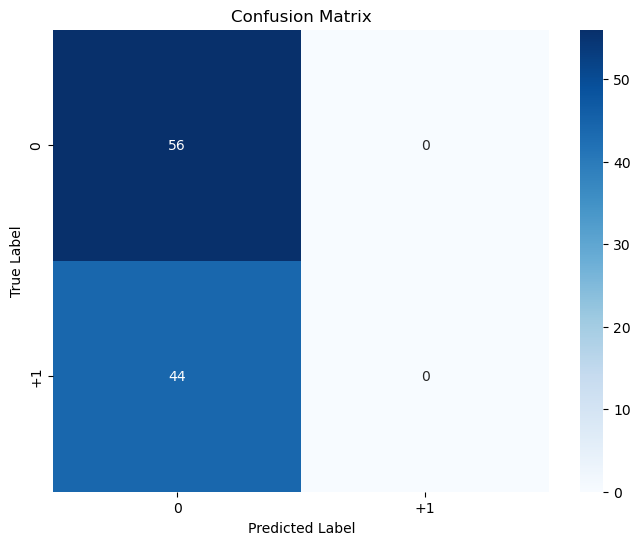

In [92]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '+1'], 
            yticklabels=['0', '+1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        56
           1       0.00      0.00      0.00        44

    accuracy                           0.56       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.31      0.56      0.40       100



Pour evalue bien notre model on fait l'entrainement sur le train_dataset uniqement est on separer le dataset avec train_test_split de sklearn.

In [103]:

dataset = pd.read_csv('dataset_minimiser.csv')
X = dataset.iloc[:,:-1]
y = dataset['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
y_pred = XGBoost_classifier(X_train, y_train, X_test, n_estimators=7, learning_rate=0.1, max_depth=2)

Accuracy: 0.55
F1 Score: 0.6666666666666667


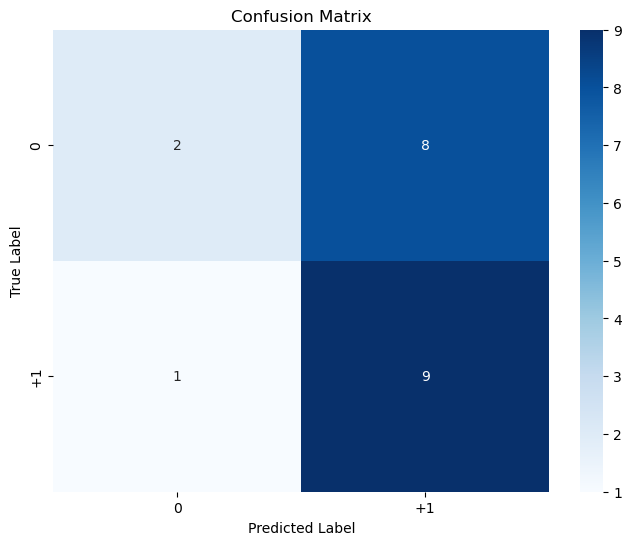

In [105]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '+1'], 
            yticklabels=['0', '+1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.53      0.90      0.67        10

    accuracy                           0.55        20
   macro avg       0.60      0.55      0.49        20
weighted avg       0.60      0.55      0.49        20



# Implementation of an XGBoost model for binary classification using Python and the XGBoost library:

In [83]:
X_train = train_dataset.iloc[:, :-1]
X_test = test_dataset.iloc[:, :-1]
y_train = train_dataset['labels']
y_test = test_dataset['labels']

model = xgb.XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=3)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Accuracy: 0.71
F1 Score: 0.6233766233766234


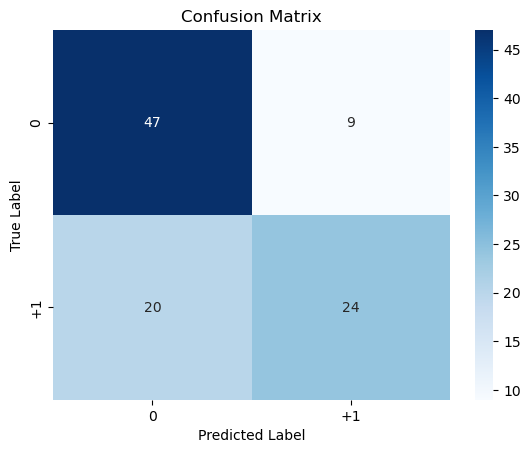

In [84]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '+1'], 
            yticklabels=['0', '+1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.84      0.76        56
           1       0.73      0.55      0.62        44

    accuracy                           0.71       100
   macro avg       0.71      0.69      0.69       100
weighted avg       0.71      0.71      0.70       100



### Performance comparison between the two XGBoost models:

The XGBoost_classifier() model shows lower accuracy and recall scores for both classes compared to the Python library xgboost() model. For class 0, the "xgboost()" model shows better accuracy and recall (0.70 and 0.84 respectively) compared to the XGBoost_classifier() model (0.67 and 0.20 respectively). Similarly, for class 1, the xgboost() model gets better accuracy and recall scores (0.73 and 0.55 respectively) compared to the XGBoost_classifier() model (0.53 and 0.90 respectively).

In summary, the Python "xgboost()" model seems better balanced, with better prediction capabilities for both classes, leading to better overall accuracy and better ability to generalize over the data.

## Performance comparison between the two models Gaussian vs XGBoost:

The Gaussian model has an accuracy of 0.50 for class 0, which means that it correctly identifies half of the elements belonging to this class, but it has no recall for class 1, which indicates that it could not correctly identify a single element of this class. As a result, its f1-score for class 1 is 0.00. Overall, the accuracy of the model is 0.50.

On the other hand, the XGBoost model has a higher accuracy for class 1 (0.53) compared to the Gaussian model, but has a lower recall for class 0 (0.20 vs. 1.00 for the Gaussian model). The accuracy of the XGBoost model is 0.55.

In general, we can say that XGBoost is the best model for this type of dataset.